# Question 5: Label Propagation pour récupérer les attributs manquants

**Algorithme implémenté**: Random Walk Method

In [ ]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Question 5(b): Implémentation de l'algorithme de Label Propagation

Implémentation **itérative** avec PyTorch pour les calculs matriciels et NetworkX pour le graphe.

In [ ]:
class LabelPropagationPyTorch:
    def __init__(self, graph, max_iter=100, tol=1e-6, verbose=True, device='cpu'):
        self.graph = graph
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.device = torch.device(device)
        
        self.A = None  # Matrice d'adjacence
        self.D = None  # Matrice des degrés
        self.P = None  # Matrice de transition
        self.Y = None  # Matrice des labels (one-hot encoding)
        self.node_list = None  # Liste ordonnée des nœuds
        self.label_encoder = None
        self.n_classes = None
        
    def _print_step(self, message):
        """pour afficher un message à chaque step"""
        if self.verbose:
            print(f"  {message}")
    
    def fit(self, attribute_name, labeled_nodes, unlabeled_nodes):
        """
        Exécute l'algorithme de label propagation pour un attribut attribute_name
        """
        if self.verbose:
            print(f"LABEL PROPAGATION (PyTorch): {attribute_name}")
        
        self.node_list = list(self.graph.nodes())
        n_nodes = len(self.node_list)
        self._print_step(f"  Nœuds: {n_nodes}")
        self._print_step(f"  Unlabeled: {len(unlabeled_nodes)}")
        
        node_to_idx = {node: i for i, node in enumerate(self.node_list)}
        true_labels = [self.graph.nodes[node][attribute_name] for node in labeled_nodes]
        
        self.label_encoder = LabelEncoder()
        encoded_labels = self.label_encoder.fit_transform(true_labels)
        self.n_classes = len(self.label_encoder.classes_)
        self._print_step(f"Classes de labelencoder: {self.n_classes} ({list(self.label_encoder.classes_)})")
        
        
        # initialize A
        A_sparse = nx.adjacency_matrix(self.graph, nodelist=self.node_list)
        A_dense = A_sparse.toarray()
        self.A = torch.from_numpy(A_dense).float().to(self.device)
        self._print_step(f"  Shape de A: {self.A.shape}")
        
        # 1 : Compute Dii = sumj (Aij)
        degrees = self.A.sum(dim=1)
        self.D = torch.diag(degrees)
        self._print_step(f"  Degré min: {degrees.min():.0f}, max: {degrees.max():.0f}, moyen: {degrees.mean():.2f}")
        
        # 2 : Compute P = D^(-1) A
        
        D_inv_diag = 1.0 / (degrees + 1e-10)
        D_inv = torch.diag(D_inv_diag)
        self.P = torch.mm(D_inv, self.A)
        
        row_sums = self.P.sum(dim=1)
        self._print_step(f" somme ligne min={row_sums.min():.4f}, max={row_sums.max():.4f}")
        
        # 3 : Initialize Y^(0) = (Y_l, 0)
        
        self.Y = torch.zeros((n_nodes, self.n_classes), device=self.device)
        
        for node, label in zip(labeled_nodes, encoded_labels):
            idx = node_to_idx[node]
            self.Y[idx, label] = 1.0
        
        self._print_step(f" Shape de Y: {self.Y.shape}")

        labeled_idx = torch.tensor([node_to_idx[node] for node in labeled_nodes], 
                                   dtype=torch.long, device=self.device)
        unlabeled_idx = torch.tensor([node_to_idx[node] for node in unlabeled_nodes],
                                     dtype=torch.long, device=self.device)
        
        Y_labeled_init = self.Y[labeled_idx].clone()
        
        # 4 : repeat
        
        for iteration in range(self.max_iter):
            Y_old = self.Y.clone()
            
            # 5 : Y^(t+1) ← P · Y^(t)
            self.Y = torch.mm(self.P, self.Y)
            
            # 6 : Y_l^(t+1) = Y_l^(t)
            self.Y[labeled_idx] = Y_labeled_init
            
            # 7 : until convergence (diff plus petit qu'un seuil)
            diff = torch.abs(self.Y - Y_old).max().item()
            
            if self.verbose and (iteration % 10 == 0 or iteration < 5):
                self._print_step(f"Itération {iteration+1}: diff={diff:.6f}")
            
            if diff < self.tol:
                self._print_step(f"Convergence atteinte à l'itération {iteration+1}")
                break
        else:
            self._print_step(f"Max iterations atteint sans convergence ({self.max_iter})")
        
        # 8 : Ŷ = Y^(t)
        predictions = {}
        for node in unlabeled_nodes:
            idx = node_to_idx[node]
            predicted_class_idx = torch.argmax(self.Y[idx]).item()
            predicted_label = self.label_encoder.inverse_transform([predicted_class_idx])[0]
            predictions[node] = predicted_label
        
        self._print_step(f"Prédictions effectuées: {len(predictions)}")
        
        return predictions

## Question 5(c): Expériences sur le dataset Facebook100

Test avec:
- 3 attributs: `dorm`, `major_index`, `gender`
- 3 fractions: 10%, 20%, 30%
- 1 réseau (vous pouvez changer)

In [ ]:
data_dir = Path("data")
network_file = "Caltech36.gml"
attributes = ['dorm', 'major_index', 'gender']
fractions = [0.1, 0.2, 0.3]

In [7]:
G = nx.read_gml(data_dir / network_file)
print(f"Nœuds: {G.number_of_nodes()}")
print(f"Arêtes: {G.number_of_edges()}")

# on se permet de prendre la LCC
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    print(f"LCC: {G.number_of_nodes()} nœuds, {G.number_of_edges()} arêtes")

sample_node = list(G.nodes())[0]
available_attrs = list(G.nodes[sample_node].keys())
print(f"Attributs disponibles: {available_attrs}")

Nœuds: 769
Arêtes: 16656
LCC: 762 nœuds, 16651 arêtes
Attributs disponibles: ['student_fac', 'gender', 'major_index', 'second_major', 'dorm', 'year', 'high_school']


In [ ]:
def prepare_nodes(G, attribute_name, fraction_to_remove):
    """
    c) on retire de manière random fraction_to_remove*100 % d'attributs de noeuds 
    """
    valid_nodes = [
        node for node in G.nodes() 
        if G.nodes[node].get(attribute_name, 0) != 0
    ]
    
    n_to_remove = int(len(valid_nodes) * fraction_to_remove)
    
    np.random.shuffle(valid_nodes)
    unlabeled_nodes = valid_nodes[:n_to_remove]
    labeled_nodes = valid_nodes[n_to_remove:]
    return labeled_nodes, unlabeled_nodes

def evaluate_predictions(G, attribute_name, unlabeled_nodes, predictions):
    """
    Évalue les prédictions avec accuracy (formule du sujet) et MAE
    accuracy(y, ŷ) = (1/n_samples) * Σ 1(ŷi = yi)
    """
    y_true = [G.nodes[node][attribute_name] for node in unlabeled_nodes]
    y_pred = [predictions[node] for node in unlabeled_nodes]
    n_samples = len(y_true)
    correct_predictions = sum(1 if y_pred[i] == y_true[i] else 0 for i in range(n_samples))
    accuracy = correct_predictions / n_samples
    
    # Mean Absolute Error
    # On a des labels catégoriels
    # Donc on dit que MAE = 1 - accuracy
    mae = 1 - accuracy  # Proportion d'erreurs
    return accuracy, mae

In [ ]:
all_results = []

np.random.seed(42)

for attribute in attributes:    
    for fraction in fractions:        
        labeled_nodes, unlabeled_nodes = prepare_nodes(G, attribute, fraction)
        lp = LabelPropagationPyTorch(G, max_iter=100, tol=1e-6, verbose=True, device=str(device))
        predictions = lp.fit(attribute, labeled_nodes, unlabeled_nodes)
        accuracy, mae = evaluate_predictions(G, attribute, unlabeled_nodes, predictions)
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Mean Absolute Error: {mae:.4f}")

        all_results.append({
            'network': network_file.replace('.gml', ''),
            'attribute': attribute,
            'fraction_removed': fraction,
            'n_labeled': len(labeled_nodes),
            'n_unlabeled': len(unlabeled_nodes),
            'accuracy': accuracy,
            'mae': mae
        })

LABEL PROPAGATION (PyTorch): dorm
    Nœuds: 762
    Unlabeled: 59
  Classes de labelencoder: 8 ([np.int64(165), np.int64(166), np.int64(167), np.int64(168), np.int64(169), np.int64(170), np.int64(171), np.int64(172)])
    Shape de A: torch.Size([762, 762])
    Degré min: 1, max: 248, moyen: 43.70
   somme ligne min=1.0000, max=1.0000
   Shape de Y: torch.Size([762, 8])
  Itération 1: diff=1.000000
  Itération 2: diff=0.292259
  Itération 3: diff=0.091121
  Itération 4: diff=0.051857
  Itération 5: diff=0.036979
  Itération 11: diff=0.006404
  Itération 21: diff=0.000239
  Itération 31: diff=0.000009
  Convergence atteinte à l'itération 38
  Prédictions effectuées: 59
  Accuracy: 0.8475
  Mean Absolute Error: 0.1525
LABEL PROPAGATION (PyTorch): dorm
    Nœuds: 762
    Unlabeled: 118
  Classes de labelencoder: 8 ([np.int64(165), np.int64(166), np.int64(167), np.int64(168), np.int64(169), np.int64(170), np.int64(171), np.int64(172)])
    Shape de A: torch.Size([762, 762])
    Degré min: 

## Question 5(d): Résultats et visualisations

In [ ]:
df_results = pd.DataFrame(all_results)
output_dir = Path('outputs/question5')
output_dir.mkdir(parents=True, exist_ok=True)
df_results.to_csv(output_dir / 'label_propagation_results_pytorch.csv', index=False)

print(df_results.to_string(index=False))

  network   attribute  fraction_removed  n_labeled  n_unlabeled  accuracy      mae
Caltech36        dorm               0.1        535           59  0.847458 0.152542
Caltech36        dorm               0.2        476          118  0.898305 0.101695
Caltech36        dorm               0.3        416          178  0.859551 0.140449
Caltech36 major_index               0.1        619           68  0.176471 0.823529
Caltech36 major_index               0.2        550          137  0.255474 0.744526
Caltech36 major_index               0.3        481          206  0.218447 0.781553
Caltech36      gender               0.1        630           69  0.695652 0.304348
Caltech36      gender               0.2        560          139  0.683453 0.316547
Caltech36      gender               0.3        490          209  0.641148 0.358852


In [12]:
pivot_accuracy = df_results.pivot(index='attribute', columns='fraction_removed', values='accuracy')
pivot_accuracy.columns = [f"{c*100:.0f}%" for c in pivot_accuracy.columns]

print(f"Réseau: {network_file.replace('.gml', '')}")
print("\nAccuracy:")
print(pivot_accuracy.to_string())

pivot_mae = df_results.pivot(index='attribute', columns='fraction_removed', values='mae')
pivot_mae.columns = [f"{c*100:.0f}%" for c in pivot_mae.columns]

print("\nMAE-score (macro):")
print(pivot_mae.to_string())

Réseau: Caltech36

Accuracy:
                  10%       20%       30%
attribute                                
dorm         0.847458  0.898305  0.859551
gender       0.695652  0.683453  0.641148
major_index  0.176471  0.255474  0.218447

MAE-score (macro):
                  10%       20%       30%
attribute                                
dorm         0.152542  0.101695  0.140449
gender       0.304348  0.316547  0.358852
major_index  0.823529  0.744526  0.781553


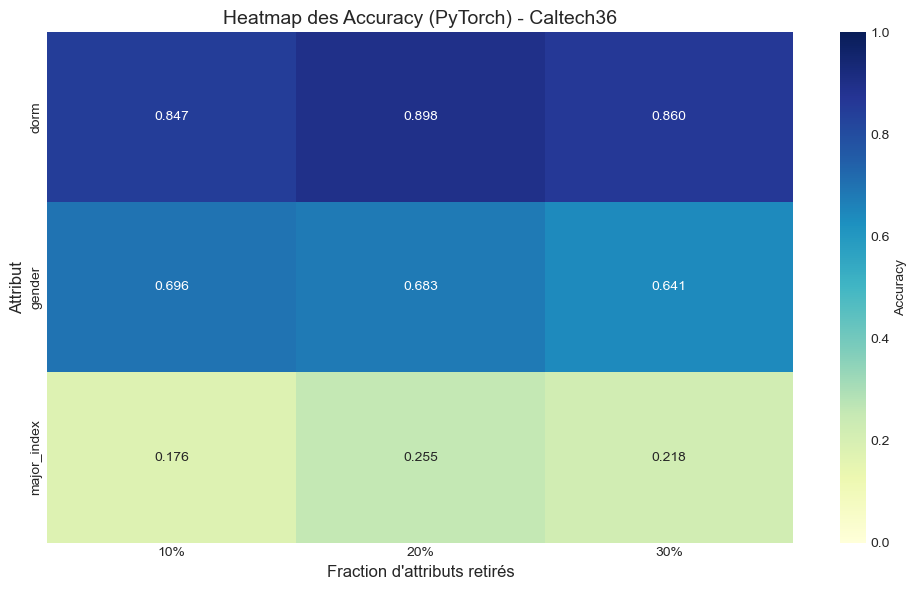

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(pivot_accuracy, annot=True, fmt='.3f', cmap='YlGnBu', 
            cbar_kws={'label': 'Accuracy'}, ax=ax, vmin=0, vmax=1)

ax.set_title(f'Heatmap des Accuracy (PyTorch) - {network_file.replace(".gml", "")}', fontsize=14)
ax.set_xlabel('Fraction d\'attributs retirés', fontsize=12)
ax.set_ylabel('Attribut', fontsize=12)

plt.tight_layout()
plt.savefig(output_dir / 'heatmap_accuracy_pytorch.png', dpi=300, bbox_inches='tight')
plt.show()


### On refait la question3 mais que pour Caltech36

In [1]:
def compute_assortativity_categorical(G, attribute):
    "Cette fonction permet de calculer l'assortativity pour les attributs catégoriques."
    "on est parti du principe que quand un attribut catégorique prend la valeur 0, c'est qu'il s'agit d'une valeur manquante"
    "à ignorer."
    node_attrs = {}
    for node in G.nodes():
        val = G.nodes[node].get(attribute, 0)
        if val != 0:
            node_attrs[node] = val
    
    if len(node_attrs) < 2:
        print("nan")
        return np.nan
    
    G_sub = G.subgraph(node_attrs.keys()).copy()
    nx.set_node_attributes(G_sub, node_attrs, 'attr')
    
    try:
        assortativity = nx.attribute_assortativity_coefficient(G_sub, 'attr')
        return assortativity
    except:
        return np.nan


def compute_degree_assortativity(G):
    try:
        return nx.degree_assortativity_coefficient(G)
    except:
        return np.nan

In [11]:
from pathlib import Path
from tqdm import tqdm

data_dir = Path("data/Caltech36.gml")

In [13]:
import networkx as nx
import pandas as pd

attributes = {
    'major_index': 'Major',
    'dorm': 'Dorm',
    'gender': 'Gender'
}

results = []

try:
    G = nx.read_gml(data_dir)
    
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
    
    network_name = data_dir.stem
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    result = {
        'network': network_name,
        'n_nodes': num_nodes,
        'n_edges': num_edges
    }
    
    result['degree'] = compute_degree_assortativity(G)
    
    for attr_key, attr_name in attributes.items():
        result[attr_key] = compute_assortativity_categorical(G, attr_key)
    
    results.append(result)
    
except Exception as e:
    print(f"Erreur avec {data_dir.name}: {e}")


df = pd.DataFrame(results)
print("aperçu")
print(df.head())

aperçu
     network  n_nodes  n_edges    degree  major_index      dorm    gender
0  Caltech36      762    16651 -0.066171     0.038181  0.448625  0.053988
